## Imports

In [1]:
import os
import re
from scipy import ndimage, misc
import cv2
from skimage.transform import resize, rescale
from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np
import pickle
np.random.seed(0)
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from google.colab.patches import cv2_imshow
import imageio
import glob
import os
import time
import cv2
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from tensorflow import keras 
import keras.backend as K
import tensorflow as tf

#Dataset

##Download Dataset ***`Don't Execute`***

In [2]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"

In [3]:
!kaggle datasets download -d prondeau/the-car-connection-picture-dataset

 99% 672M/682M [00:12<00:00, 56.4MB/s]
100% 682M/682M [00:12<00:00, 57.8MB/s]


In [4]:
!unzip '/content/the-car-connection-picture-dataset.zip' -d '/content/data'

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/Toyota_Sequoia_2019_60_20_380_57_8_79_77_205_13_4WD_8_4_SUV_Fel.jpg  
  inflating: /content/data/Toyota_Sequoia_2019_60_20_380_57_8_79_77_205_13_4WD_8_4_SUV_GON.jpg  
  inflating: /content/data/Toyota_Sequoia_2019_60_20_380_57_8_79_77_205_13_4WD_8_4_SUV_JXa.jpg  
  inflating: /content/data/Toyota_Sequoia_2019_60_20_380_57_8_79_77_205_13_4WD_8_4_SUV_LNH.jpg  
  inflating: /content/data/Toyota_Sequoia_2019_60_20_380_57_8_79_77_205_13_4WD_8_4_SUV_LhY.jpg  
  inflating: /content/data/Toyota_Sequoia_2019_60_20_380_57_8_79_77_205_13_4WD_8_4_SUV_LlQ.jpg  
  inflating: /content/data/Toyota_Sequoia_2019_60_20_380_57_8_79_77_205_13_4WD_8_4_SUV_MOs.jpg  
  inflating: /content/data/Toyota_Sequoia_2019_60_20_380_57_8_79_77_205_13_4WD_8_4_SUV_MTX.jpg  
  inflating: /content/data/Toyota_Sequoia_2019_60_20_380_57_8_79_77_205_13_4WD_8_4_SUV_MxF.jpg  
  inflating: /content/data/Toyota_Sequoia_2019_60_20_380_57_8_79_77_205_13_4

##Prepare Dataset ***`Don't Execute`***

In [5]:
path = '/content/data/'

In [6]:
files = os.listdir(path)

In [7]:
files = files[:len(files) // 8] #Because The Google Colab's RAM Is not large 
                                #So We Take Only The First Half Of The Dataset

In [8]:
#Add Some Motion Blur Effect
kernel_size = 10
kernel_v = np.zeros((kernel_size, kernel_size))
kernel_v[:, int((kernel_size - 1)/2)] = np.ones(kernel_size)
kernel_v /= kernel_size

In [9]:
DATASET_SIZE = len(files)
IMG_HEIGHT = 100
IMG_WIDTH = 100

In [10]:
X = np.zeros((DATASET_SIZE,IMG_HEIGHT,IMG_WIDTH,3))
y = np.zeros((DATASET_SIZE,IMG_HEIGHT,IMG_WIDTH,3))
for index , filename in enumerate(files):
  img = cv2.imread(path + filename)
  img = cv2.resize(img, (IMG_HEIGHT,IMG_WIDTH)) / 255
  X[index] = cv2.filter2D(img, -1, kernel_v)
  y[index] = img

In [11]:
dataset = tf.data.Dataset.from_tensor_slices((X,y)).batch(8)

In [12]:
del X,y

#Define the model

## Parameters

In [13]:
# Define global constants to be used in this notebook
BATCH_SIZE=128
LATENT_DIM=10

## Build Model Architecture


<img src="https://drive.google.com/uc?export=view&id=1YAZAeMGEJ1KgieYk1ju-S9DoshpMREeC" width="60%" height="60%"/>



In [17]:
class Sampling(tf.keras.layers.Layer):
  def call(self, inputs):
    """Generates a random sample and combines with the encoder output
    
    Args:
      inputs -- output tensor from the encoder

    Returns:
      `inputs` tensors combined with a random sample
    """

    # unpack the output of the encoder
    mu, sigma = inputs

    # get the size and dimensions of the batch
    batch = tf.shape(mu)[0]
    dim = tf.shape(mu)[1]

    # generate a random tensor
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))

    # combine the inputs and noise
    return mu + tf.exp(0.5 * sigma) * epsilon

### Encoder



<img src="https://drive.google.com/uc?export=view&id=1eoxFK_UVSHd3a_5EHcCU8F8QDZlPiXfW" width="60%" height="60%"/>

In [18]:
def encoder_layers(inputs, latent_dim):
  """Defines the encoder's layers.
  Args:
    inputs -- batch from the dataset
    latent_dim -- dimensionality of the latent space

  Returns:
    mu -- learned mean
    sigma -- learned standard deviation
    batch_2.shape -- shape of the features before flattening
  """

  # add the Conv2D layers followed by BatchNormalization
  x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding="same", activation='relu', name="encode_conv1")(inputs)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu', name="encode_conv2")(x)

  # assign to a different variable so you can extract the shape later
  batch_2 = tf.keras.layers.BatchNormalization()(x)

  # flatten the features and feed into the Dense network
  x = tf.keras.layers.Flatten(name="encode_flatten")(batch_2)

  # we arbitrarily used 20 units here but feel free to change and see what results you get
  x = tf.keras.layers.Dense(20, activation='relu', name="encode_dense")(x)
  x = tf.keras.layers.BatchNormalization()(x)

  # add output Dense networks for mu and sigma, units equal to the declared latent_dim.
  mu = tf.keras.layers.Dense(latent_dim, name='latent_mu')(x)
  sigma = tf.keras.layers.Dense(latent_dim, name ='latent_sigma')(x)

  return mu, sigma, batch_2.shape

In [19]:
def encoder_model(latent_dim, input_shape):
  """Defines the encoder model with the Sampling layer
  Args:
    latent_dim -- dimensionality of the latent space
    input_shape -- shape of the dataset batch

  Returns:
    model -- the encoder model
    conv_shape -- shape of the features before flattening
  """

  # declare the inputs tensor with the given shape
  inputs = tf.keras.layers.Input(shape=input_shape)

  # get the output of the encoder_layers() function
  mu, sigma, conv_shape = encoder_layers(inputs, latent_dim=LATENT_DIM)

  # feed mu and sigma to the Sampling layer
  z = Sampling()((mu, sigma))

  # build the whole encoder model
  model = tf.keras.Model(inputs, outputs=[mu, sigma, z])

  return model, conv_shape

### Decoder


In [20]:
def decoder_layers(inputs, conv_shape):
  """Defines the decoder layers.
  Args:
    inputs -- output of the encoder 
    conv_shape -- shape of the features before flattening

  Returns:
    tensor containing the decoded output
  """

  # feed to a Dense network with units computed from the conv_shape dimensions
  units = conv_shape[1] * conv_shape[2] * conv_shape[3]
  x = tf.keras.layers.Dense(units, activation = 'relu', name="decode_dense1")(inputs)
  x = tf.keras.layers.BatchNormalization()(x)
  
  # reshape output using the conv_shape dimensions
  x = tf.keras.layers.Reshape((conv_shape[1], conv_shape[2], conv_shape[3]), name="decode_reshape")(x)

  # upsample the features back to the original dimensions
  x = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu', name="decode_conv2d_2")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu', name="decode_conv2d_3")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=3, strides=1, padding='same', activation='sigmoid', name="decode_final")(x)
  
  return x

In [21]:
def decoder_model(latent_dim, conv_shape):
  """Defines the decoder model.
  Args:
    latent_dim -- dimensionality of the latent space
    conv_shape -- shape of the features before flattening

  Returns:
    model -- the decoder model
  """

  # set the inputs to the shape of the latent space
  inputs = tf.keras.layers.Input(shape=(latent_dim,))

  # get the output of the decoder layers
  outputs = decoder_layers(inputs, conv_shape)

  # declare the inputs and outputs of the model
  model = tf.keras.Model(inputs, outputs)
  
  return model

### Kullback–Leibler Divergence

In [22]:
def kl_reconstruction_loss(inputs, outputs, mu, sigma):
  """ Computes the Kullback-Leibler Divergence (KLD)
  Args:
    inputs -- batch from the dataset
    outputs -- output of the Sampling layer
    mu -- mean
    sigma -- standard deviation

  Returns:
    KLD loss
  """
  kl_loss = 1 + sigma - tf.square(mu) - tf.math.exp(sigma)
  kl_loss = tf.reduce_mean(kl_loss) * -0.5

  return kl_loss

### VAE Model

In [23]:
def vae_model(encoder, decoder, input_shape):
  """Defines the VAE model
  Args:
    encoder -- the encoder model
    decoder -- the decoder model
    input_shape -- shape of the dataset batch

  Returns:
    the complete VAE model
  """

  # set the inputs
  inputs = tf.keras.layers.Input(shape=input_shape)

  # get mu, sigma, and z from the encoder output
  mu, sigma, z = encoder(inputs)
  
  # get reconstructed output from the decoder
  reconstructed = decoder(z)

  # define the inputs and outputs of the VAE
  model = tf.keras.Model(inputs=inputs, outputs=reconstructed)

  # add the KL loss
  loss = kl_reconstruction_loss(inputs, z, mu, sigma)
  model.add_loss(loss)

  return model

We'll add a helper function to setup and get the different models from the functions you defined.

In [24]:
def get_models(input_shape, latent_dim):
  """Returns the encoder, decoder, and vae models"""
  encoder, conv_shape = encoder_model(latent_dim=latent_dim, input_shape=input_shape)
  decoder = decoder_model(latent_dim=latent_dim, conv_shape=conv_shape)
  vae = vae_model(encoder, decoder, input_shape=input_shape)
  return encoder, decoder, vae

In [25]:
# Get the encoder, decoder and 'master' model (called vae)
encoder, decoder, vae = get_models(input_shape=(IMG_HEIGHT,IMG_WIDTH,3), latent_dim=LATENT_DIM)

In [26]:
encoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 encode_conv1 (Conv2D)          (None, 50, 50, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 50, 50, 32)  128         ['encode_conv1[0][0]']           
 alization)                                                                                       
                                                                                              

In [27]:
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10)]              0         
                                                                 
 decode_dense1 (Dense)       (None, 40000)             440000    
                                                                 
 batch_normalization_3 (Batc  (None, 40000)            160000    
 hNormalization)                                                 
                                                                 
 decode_reshape (Reshape)    (None, 25, 25, 64)        0         
                                                                 
 decode_conv2d_2 (Conv2DTran  (None, 50, 50, 64)       36928     
 spose)                                                          
                                                                 
 batch_normalization_4 (Batc  (None, 50, 50, 64)       256 

## Train the Model

In [28]:
# Define our loss functions and optimizers
optimizer = tf.keras.optimizers.Adam()
loss_metric = tf.keras.metrics.Mean()
bce_loss = tf.keras.losses.BinaryCrossentropy()

In [29]:
def generate_and_save_images(model, epoch, step, test_input):
  """Helper function to plot our 16 images

  Args:

  model -- the decoder model
  epoch -- current epoch number during training
  step -- current step number during training
  test_input -- random tensor with shape (16, LATENT_DIM)
  """

  # generate images from the test input
  predictions = model.predict(test_input)

  # plot the results
  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0], cmap='gray')
      plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  fig.suptitle("epoch: {}, step: {}".format(epoch, step))
  plt.savefig('image_at_epoch_{:04d}_step{:04d}.png'.format(epoch, step))
  plt.show()

In [ ]:
# Training loop. 

# generate random vector as test input to the decoder
random_vector_for_generation = tf.random.normal(shape=[16, LATENT_DIM])

# number of epochs
epochs = 100

# initialize the helper function to display outputs from an untrained model
generate_and_save_images(decoder, 0, 0, random_vector_for_generation)

for epoch in range(epochs):
  print('Start of epoch %d' % (epoch,))

  # iterate over the batches of the dataset.
  for step, (x_batch_train,y_batch_train) in enumerate(dataset):
    with tf.GradientTape() as tape:

      # feed a batch to the VAE model
      reconstructed = vae(x_batch_train)

      # compute reconstruction loss
      flattened_inputs = tf.reshape(y_batch_train, shape=[-1])
      flattened_outputs = tf.reshape(reconstructed, shape=[-1])
      loss = bce_loss(flattened_inputs, flattened_outputs) * 784
      
      # add KLD regularization loss
      loss += sum(vae.losses)  

    # get the gradients and update the weights
    grads = tape.gradient(loss, vae.trainable_weights)
    optimizer.apply_gradients(zip(grads, vae.trainable_weights))

    # compute the loss metric
    loss_metric(loss)

    # display outputs every 100 steps
    if step % 100 == 0:
      display.clear_output(wait=False)    
      generate_and_save_images(decoder, epoch, step, random_vector_for_generation)
      print('Epoch: %s step: %s mean loss = %s' % (epoch, step, loss_metric.result().numpy()))

#Results

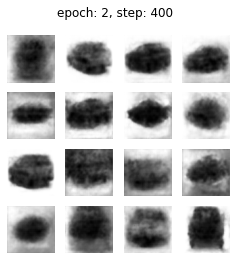









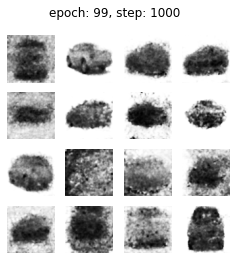